## 範例重點
* 學習如何在 keras 中加入 EarlyStop
* 知道如何設定監控目標
* 比較有無 earlystopping 對 validation 的影響

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

PATIENCE = [5,10,25]

In [7]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from keras.callbacks import EarlyStopping


In [8]:
results = {}

for patience_number in PATIENCE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with PATIENCE = %.1f" % (patience_number))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    earlystop = EarlyStopping(monitor="val_acc", 
                          patience=patience_number, 
                          verbose=1,
                          mode="auto")                                

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "PATIENCE-%s" % str(patience_number)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with PATIENCE = 5.0
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________

Epoch 12/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.2448 - acc: 0.5684 - val_loss: 1.4877 - val_acc: 0.4794
Epoch 13/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.2194 - acc: 0.5796 - val_loss: 1.4771 - val_acc: 0.4848
Epoch 14/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1947 - acc: 0.5888 - val_loss: 1.4669 - val_acc: 0.4872
Epoch 15/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1699 - acc: 0.5966 - val_loss: 1.4666 - val_acc: 0.4849
Epoch 16/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1476 - acc: 0.6072 - val_loss: 1.4542 - val_acc: 0.4957
Epoch 17/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.1240 - acc: 0.6146 - val_loss: 1.4685 - val_acc: 0.4921
Epoch 18/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.1027 - acc: 0.6217 - val_loss: 1.4508 - val_acc: 0.4967
Epoch 19/50
50000/50000 [=========

50000/50000 [==============================] - 2s 39us/step - loss: 1.1625 - acc: 0.5998 - val_loss: 1.4748 - val_acc: 0.4817
Epoch 17/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1387 - acc: 0.6089 - val_loss: 1.4742 - val_acc: 0.4857
Epoch 18/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1170 - acc: 0.6182 - val_loss: 1.4604 - val_acc: 0.4841
Epoch 19/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0929 - acc: 0.6271 - val_loss: 1.4593 - val_acc: 0.4880
Epoch 20/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0718 - acc: 0.6348 - val_loss: 1.4578 - val_acc: 0.4910
Epoch 21/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0490 - acc: 0.6423 - val_loss: 1.4525 - val_acc: 0.4891
Epoch 22/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.0259 - acc: 0.6526 - val_loss: 1.4677 - val_acc: 0.4866
Epoch 23/50
50000/50000 [=====================

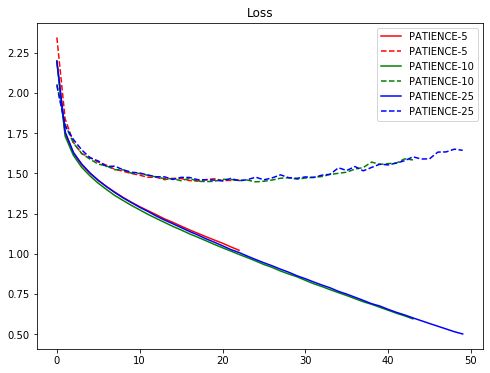

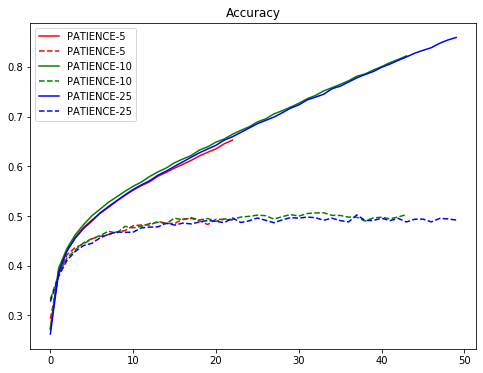

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))

for i, cond in enumerate(results.keys()):

    #plt.plot(range(len(train_loss)), train_loss, label="train loss")
    #plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])

plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    #plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    #plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])

plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果